# Imports

In [1]:
import copy
import numpy as np
import ml_collections
import matplotlib.pyplot as plt
import os
import math
from os.path import join as pjoin
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torchvision import transforms as T
from torch.nn.modules.utils import _pair
from torch.utils.data import DataLoader, Dataset, random_split
import PIL
from PIL import Image
from scipy import ndimage

from collections import OrderedDict

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


# Dataset y Dataloader

In [3]:
base_path = '/home/eoyarce/segmentacion-tesis-2/model/data_new'
TRAIN_PATH = os.path.join(base_path, 'ImagesPNG')
TRAIN_MASKS_PATH = os.path.join(base_path, 'Mask_0.4')

## Dataset

In [4]:
# creamos nuestro propio Dataset
class CustomDataset(Dataset):
    def __init__(self, data_path, masks_path, img_transforms=None, mask_transforms=None):
        """
        data_path - train data path
        masks_path - train masks path
        """
        self.train_data = data_path
        self.train_masks = masks_path

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))

    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images) == len(self.masks), 'Not the same number of images and masks'
        return len(self.images)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img = trans(img)

        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            
            # Normalizamos las mascaras para que sean 0s y 1s, estamos segmentando glaciares
            mask_max = mask.max().item()
            mask = mask/mask_max
        else:
            return img
        
        return img, mask

## Dataloaders

In [5]:
transform_data = T.Compose([
    T.Resize([224, 224]),	
    T.ToTensor(),
])

In [6]:
full_dataset = CustomDataset(TRAIN_PATH, TRAIN_MASKS_PATH, img_transforms=transform_data, mask_transforms=transform_data)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
BATCH_SIZE = 16

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
for i, (x, y) in enumerate (train_loader):
    print(i, x.shape, y.shape)
    if i == 9:
        break

0 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
1 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
2 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
3 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
4 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
5 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
6 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
7 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
8 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
9 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])


## Veamos la data

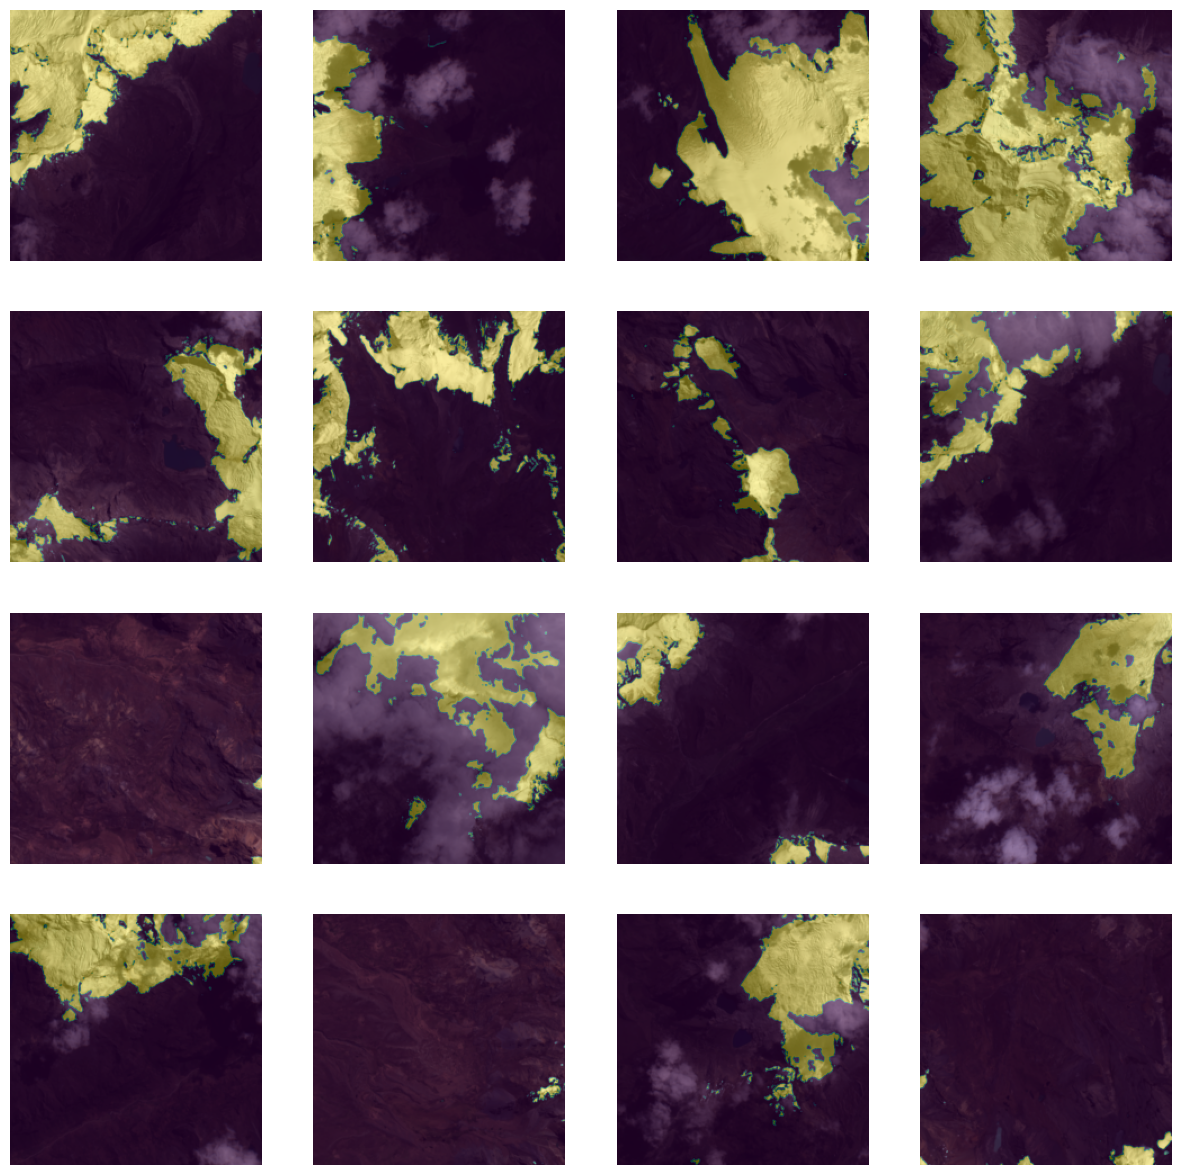

In [9]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(imgs[i*4+j].permute(1, 2, 0))
            axs[i, j].imshow(masks[i*4+j].permute(1, 2, 0).squeeze(), alpha=0.4)
            axs[i, j].axis('off')
    plt.show()
plot_mini_batch(imgs, masks)

# Implementación del modelo

In [ ]:
# Código adaptado de: https://github.com/Beckschen/TransUNet

In [ ]:
# El ViT-16B y la ResNet50 empleados en este código ha sido pre-entrenado con imagenet21k por el mismo autor del paper
# Link para descarga: https://console.cloud.google.com/storage/vit_models/

## Config

In [10]:
# Configuración del ViT-16B
def get_b16_config():
    """Devuelve la configuración del ViT-B/16."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1

    config.classifier = 'seg'
    config.representation_size = None
    config.resnet_pretrained_path = None
    config.pretrained_path = "D:\\PUCP\\2024-1\\Deep Learning\\TA\\bomboclat-deep-learning\\model\\ViT-B_16.npz"
    config.patch_size = 16

    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 2
    config.activation = 'softmax'
    return config

# Configuración de la Resnet50 con ViT-16B
def get_r50_b16_config():
    """Devuelve la configuración del Resnet50 + ViT-B/16."""
    config = get_b16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.pretrained_path = "/home/eoyarce/segmentacion-tesis-2/model/R50+ViT-B_16.npz"
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.n_skip = 3
    config.activation = 'softmax'

    return config


In [11]:
def np2th(weights, conv=False):
    return torch.from_numpy(weights)


def swish(x):
    return x * torch.sigmoid(x)

In [12]:
ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"

ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}

## ResNet50

In [13]:
def np2th(weights, conv=False):
    """Posible conversion de HWIO a OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)

In [14]:
class StdConv2d(nn.Conv2d):

    def forward(self, x):
        w = self.weight
        v, m = torch.var_mean(w, dim=[1,2,3], keepdim=True, unbiased=False)
        w = (w - m) / torch.sqrt(v + 1e-5)
        return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [15]:
def conv3x3(cin, cout, stride=1, groups=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=3, stride=stride,
                     padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=1, stride=stride,
                     padding=0, bias=bias)

class PreActBottleneck(nn.Module):
    """Pre-activation bottleneck block"""
    def __init__(self, cin, cout=None, cmid=None, stride=1):
        super().__init__()
        cout = cout or cin
        cmid = cmid or cout//4

        self.gn1 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv1 = conv1x1(cin, cmid, bias=False)
        self.gn2 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv2 = conv3x3(cmid, cmid, stride, bias=False)
        self.gn3 = nn.GroupNorm(32, cout, eps=1e-6)
        self.conv3 = conv1x1(cmid, cout, bias=False)
        self.relu = nn.ReLU(inplace=True)

        if (stride != 1 or cin != cout):
            # Projection also with pre-activation according to paper.
            self.downsample = conv1x1(cin, cout, stride, bias=False)
            self.gn_proj = nn.GroupNorm(cout, cout)

    def forward(self, x):
        # Residual branch
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(x)
            residual = self.gn_proj(residual)

        # Unit's branch
        y = self.relu(self.gn1(self.conv1(x)))
        y = self.relu(self.gn2(self.conv2(y)))
        y = self.gn3(self.conv3(y))

        y = self.relu(residual + y)
        return y
    
    def load_from(self, weights, n_block, n_unit):
        conv1_weight = np2th(weights[pjoin(n_block, n_unit, "conv1/kernel").replace('\\', '/')], conv=True)
        conv2_weight = np2th(weights[pjoin(n_block, n_unit, "conv2/kernel").replace('\\', '/')], conv=True)
        conv3_weight = np2th(weights[pjoin(n_block, n_unit, "conv3/kernel").replace('\\', '/')], conv=True)

        gn1_weight = np2th(weights[pjoin(n_block, n_unit, "gn1/scale").replace('\\', '/')])
        gn1_bias = np2th(weights[pjoin(n_block, n_unit, "gn1/bias").replace('\\', '/')])

        gn2_weight = np2th(weights[pjoin(n_block, n_unit, "gn2/scale").replace('\\', '/')])
        gn2_bias = np2th(weights[pjoin(n_block, n_unit, "gn2/bias").replace('\\', '/')])

        gn3_weight = np2th(weights[pjoin(n_block, n_unit, "gn3/scale").replace('\\', '/')])
        gn3_bias = np2th(weights[pjoin(n_block, n_unit, "gn3/bias").replace('\\', '/')])

        self.conv1.weight.copy_(conv1_weight)
        self.conv2.weight.copy_(conv2_weight)
        self.conv3.weight.copy_(conv3_weight)

        self.gn1.weight.copy_(gn1_weight.view(-1))
        self.gn1.bias.copy_(gn1_bias.view(-1))

        self.gn2.weight.copy_(gn2_weight.view(-1))
        self.gn2.bias.copy_(gn2_bias.view(-1))

        self.gn3.weight.copy_(gn3_weight.view(-1))
        self.gn3.bias.copy_(gn3_bias.view(-1))

        if hasattr(self, 'downsample'):
            proj_conv_weight = np2th(weights[pjoin(n_block, n_unit, "conv_proj/kernel").replace('\\', '/')], conv=True)
            proj_gn_weight = np2th(weights[pjoin(n_block, n_unit, "gn_proj/scale").replace('\\', '/')])
            proj_gn_bias = np2th(weights[pjoin(n_block, n_unit, "gn_proj/bias").replace('\\', '/')])

            self.downsample.weight.copy_(proj_conv_weight)
            self.gn_proj.weight.copy_(proj_gn_weight.view(-1))
            self.gn_proj.bias.copy_(proj_gn_bias.view(-1))


In [16]:
class ResNet(nn.Module):
    """Implementation of Pre-activation ResNet mode."""
    def __init__(self, block_units, width_factor):
        super().__init__()
        width = int(64 * width_factor)
        self.width = width

        self.root = nn.Sequential(OrderedDict([
            ('conv', StdConv2d(3, width, kernel_size=7, stride=2, bias=False, padding=3)),
            ('gn', nn.GroupNorm(32, width, eps=1e-6)),
            ('relu', nn.ReLU(inplace=True)),
            # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        ]))

        self.body = nn.Sequential(OrderedDict([
            ('block1', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width, cout=width*4, cmid=width))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*4, cout=width*4, cmid=width)) for i in range(2, block_units[0] + 1)],
                ))),
            ('block2', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*4, cout=width*8, cmid=width*2, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*8, cout=width*8, cmid=width*2)) for i in range(2, block_units[1] + 1)],
                ))),
            ('block3', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*8, cout=width*16, cmid=width*4, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*16, cout=width*16, cmid=width*4)) for i in range(2, block_units[2] + 1)],
                ))),
        ]))

    def forward(self, x):
        features = []
        b, c, in_size, _ = x.size()
        x = self.root(x)
        features.append(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)(x)
        for i in range(len(self.body)-1):
            x = self.body[i](x)
            right_size = int(in_size / 4 / (i+1))
            if x.size()[2] != right_size:
                pad = right_size - x.size()[2]
                assert pad < 3 and pad > 0, "x {} should {}".format(x.size(), right_size)
                feat = torch.zeros((b, x.size()[1], right_size, right_size), device=x.device)
                feat[:, :, 0:x.size()[2], 0:x.size()[3]] = x[:]
            else:
                feat = x
            features.append(feat)
        x = self.body[-1](x)
        return x, features[::-1]

## Transformer

In [17]:
class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
    
    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights

In [18]:
class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.droupout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.droupout(x)
        x = self.fc2(x)
        x = self.droupout(x)
        return x

In [19]:
class Embeddings(nn.Module):
    """Construcción de los embeddings desde el patch, embeddings con posición."""
    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        self.config = config
        img_size = _pair(img_size)
        self.hybrid = True

        grid_size = config.patches["grid"]
        patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
        patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
        n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1])
        self.hybrid_model = ResNet(block_units=config.resnet.num_layers, width_factor=config.resnet.width_factor)
        in_channels = self.hybrid_model.width * 16

        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])

    def forward(self, x):
        if self.hybrid:
            x, features = self.hybrid_model(x)
        else:
            features = None
        x = self.patch_embeddings(x)  # (B, hidden. n_patches^(1/2), n_patches^(1/2))
        x = x.flatten(2)
        x = x.transpose(-1, -2)  # (B, n_patches, hidden)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings, features

In [20]:
class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)   # Normalización para la capa de atención
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)         # Normalización para la capa de red feed-forward
        self.ffn = Mlp(config)                                          # Red feed-forward (MLP)
        self.attn = Attention(config, vis)                              # Mecanismo de atención

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights
    
    def load_from(self, weights, n_block):
        # Cargar pesos desde un diccionario de pesos preentrenados
        ROOT = f"Transformer/encoderblock_{n_block}"

        # Cargar los pesos y sesgos para las capas de atención
        query_weight = np2th(weights[pjoin(ROOT, ATTENTION_Q, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
        key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
        value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
        out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()

        query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias").replace('\\', '/')]).view(-1)
        key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias").replace('\\', '/')]).view(-1)
        value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias").replace('\\', '/')]).view(-1)
        out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias").replace('\\', '/')]).view(-1)

        # Copiar los pesos y sesgos cargados a las capas de atención correspondientes
        self.attn.query.weight.copy_(query_weight)
        self.attn.key.weight.copy_(key_weight)
        self.attn.value.weight.copy_(value_weight)
        self.attn.out.weight.copy_(out_weight)
        self.attn.query.bias.copy_(query_bias)
        self.attn.key.bias.copy_(key_bias)
        self.attn.value.bias.copy_(value_bias)
        self.attn.out.bias.copy_(out_bias)

        # Cargar los pesos y sesgos para las capas de la red feed-forward
        mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel").replace('\\', '/')]).t()
        mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel").replace('\\', '/')]).t()
        mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias").replace('\\', '/')]).t()
        mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias").replace('\\', '/')]).t()

        # Copiar los pesos y sesgos cargados a las capas de la red feed-forward correspondientes
        self.ffn.fc1.weight.copy_(mlp_weight_0)
        self.ffn.fc2.weight.copy_(mlp_weight_1)
        self.ffn.fc1.bias.copy_(mlp_bias_0)
        self.ffn.fc2.bias.copy_(mlp_bias_1)

        # Cargar y copiar los pesos y sesgos para las capas de normalización
        self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale").replace('\\', '/')]))
        self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias").replace('\\', '/')]))
        self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale").replace('\\', '/')]))
        self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias").replace('\\', '/')]))

In [21]:
class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights

In [22]:
class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size = img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output, features = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights, features

## TransUnet (ViT-16)

In [23]:
class Conv2dReLU(nn.Sequential):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True
    ):
        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not(use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        bn = nn.BatchNorm2d(out_channels)

        super(Conv2dReLU, self).__init__(conv, bn, relu)

In [24]:
class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            skip_channels=0,
            use_batchnorm=True,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x, skip=None):
        x = self.up(x)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [25]:
class SegmentationHead(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        super().__init__(conv2d, upsampling)

In [26]:
class DecoderCup(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        head_channels = 512

        # Capa convolucional inicial con batch normalization y activacion ReLU
        self.conv_more = Conv2dReLU(
            config.hidden_size,     # Input channel size
            head_channels,          # Output channel size
            kernel_size=3,          # Size of the convolutional kernel
            padding=1,              # Padding size
            use_batchnorm=True,
        )

        decoder_channels = config.decoder_channels
        in_channels = [head_channels] + list(decoder_channels[:-1])
        out_channels = decoder_channels

        # Configuración de los skip connections basado en el número de skips especificado
        skip_channels = self.config.skip_channels
        for i in range(4-self.config.n_skip):
            skip_channels[3-i]=0

        # Creación de lista de bloques de decoder
        blocks = [
            DecoderBlock(in_ch, out_ch, sk_ch) for in_ch, out_ch, sk_ch in zip(in_channels, out_channels, skip_channels)
        ]

        # Conversión de la lista de bloques en un ModuleList para registrarlos como un submodulo
        self.blocks = nn.ModuleList(blocks)

    def forward(self, hidden_states, features=None):
        B, n_patch, hidden = hidden_states.size()   # Batch size, number of patches, hidden size
        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch)) # Convertir el número de patches a altura y ancho
        
        # Reajuste de hidden states para igualar el shape esperado por las capas convolucionales
        x = hidden_states.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, h, w)
        
        # Aplicación de la capa convolucional inicial
        x = self.conv_more(x)

        # Pase a través de cada bloque de decoder
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.config.n_skip) else None # Uso del skip connection
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x

In [27]:
class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier
        self.transformer = Transformer(config,img_size, vis)
        self.decoder = DecoderCup(config)
        self.segmentation_head = SegmentationHead(
            in_channels = config['decoder_channels'][-1],
            out_channels = config['n_classes'],
            kernel_size=3,
        )
        self.config = config

    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1,3,1,1)
        x, attn_weights, features = self.transformer(x)
        x = self.decoder(x, features)
        logits = self.segmentation_head(x)
        return logits

    def load_from(self, weights):
        with torch.no_grad():

            res_weight = weights
            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))

            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])

            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            elif posemb.size()[1]-1 == posemb_new.size()[1]:
                posemb = posemb[:, 1:]
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                ntok_new = posemb_new.size(1)
                if self.classifier == "seg":
                    _, posemb_grid = posemb[:, :1], posemb[0, 1:]
                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)
                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)  # th2np
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = posemb_grid
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            # Encoder whole
            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(res_weight["conv_root/kernel"], conv=True))
                gn_weight = np2th(res_weight["gn_root/scale"]).view(-1)
                gn_bias = np2th(res_weight["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(res_weight, n_block=bname, n_unit=uname)


In [28]:
img_size = 224
patches_size = 16

config_vit = get_r50_b16_config()
config_vit.n_classes = 2
config_vit.n_skip = 3
config_vit.patches.grid = (int(img_size/patches_size), int(img_size/patches_size))
TransUNet = VisionTransformer(config_vit, img_size=img_size, num_classes=config_vit.n_classes).to(device)
TransUNet.load_from(weights=np.load(config_vit.pretrained_path))

## Train model

### Accuracy

In [29]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost += F.cross_entropy(scores, y).item()
            # Standard accuracy calculation
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            # Dice coefficient calculation
            intersection += (preds * y).sum()
            denom += (preds + y).sum()
            dice = 2 * intersection / (denom + 1e-8)
            # IoU calculation
            union += (preds | y).sum()
            iou = intersection / (union + 1e-8)
    return cost / len(loader), float(correct) / total, dice.item(), iou.item()

### Search for Learning Rate

In [30]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies    

### Train loop

In [31]:
def train(model, optimizer, scheduler = None, epochs=100, store_every=25):
    model = model.to(device= device) # Activamos el gpu
    for epoch in range(epochs):
        train_correct_num = 0   # Numero de predicciones correctas
        train_total = 0 # Numero total de predicciones
        train_cost_acum = 0. # Costo acumulado
        for mb, (x, y) in enumerate (train_loader, start=1): # Iteramos sobre los minibatches
            model.train() # Activamos el modo de entrenamiento
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1) # Eliminamos la dimension de canal
            scores = model(x)
            cost = F.cross_entropy(scores, y)
            optimizer.zero_grad() # Limpiamos los gradientes
            cost.backward() # Calculamos los gradientes
            optimizer.step() # Actualizamos los pesos
            if scheduler: 
                scheduler.step() # Actualizamos el learning rate
            train_predictions = torch.argmax(scores, dim=1) # Obtenemos las predicciones
            train_correct_num += (train_predictions == y).sum() # Sumamos las predicciones correctas
            train_total += torch.numel(train_predictions) # Sumamos el numero total de predicciones
            train_cost_acum += cost.item() # Sumamos el costo
            if mb % store_every == 0: # Cada ciertos minibatches calculamos el costo y la accuracy de validacion
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num) / train_total
                train_cost = float(train_cost_acum) / mb
                print(f'Epoch {epoch}, minibatch {mb}, train cost {train_cost:.3f}, train acc {train_acc:.3f}, val cost {val_cost:.3f}, val acc {val_acc:.3f}, dice {dice:.3f}, iou {iou:.3f}')
    # Save model
    torch.save(model.state_dict(), 'TransUNetModel.pth')

### Train model

In [32]:
torch.manual_seed(42)
TransUNet = VisionTransformer(config_vit, img_size=img_size, num_classes=config_vit.n_classes).to(device)
TransUNet.load_from(weights=np.load(config_vit.pretrained_path))
model = TransUNet
#model = nn.DataParallel(model,device_ids = [1]) #[0,1,2,3])  # Para entrenar en varias tarjetas GPU
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lg_lrs, losses, accs = find_lr(model, optimizer, start_val=1e-6, end_val=1, loader=train_loader)

/home/eoyarce/anaconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


cost:0.6888, lr: 0.0000, acc: 0.2699
cost:0.6854, lr: 0.0000, acc: 0.2726
cost:0.6821, lr: 0.0000, acc: 0.2766
cost:0.6822, lr: 0.0000, acc: 0.2773
cost:0.6845, lr: 0.0000, acc: 0.2748
cost:0.6851, lr: 0.0000, acc: 0.2752
cost:0.6759, lr: 0.0000, acc: 0.2849
cost:0.6754, lr: 0.0000, acc: 0.2844
cost:0.6648, lr: 0.0000, acc: 0.2967
cost:0.6570, lr: 0.0000, acc: 0.3034
cost:0.6578, lr: 0.0000, acc: 0.3032
cost:0.6532, lr: 0.0000, acc: 0.3111
cost:0.6419, lr: 0.0000, acc: 0.3171
cost:0.6358, lr: 0.0000, acc: 0.3202
cost:0.6228, lr: 0.0001, acc: 0.3369
cost:0.6160, lr: 0.0001, acc: 0.3378
cost:0.6138, lr: 0.0001, acc: 0.3428
cost:0.5894, lr: 0.0001, acc: 0.3606
cost:0.5437, lr: 0.0002, acc: 0.4036
cost:0.5409, lr: 0.0002, acc: 0.4079
cost:0.5270, lr: 0.0003, acc: 0.4294
cost:0.4870, lr: 0.0004, acc: 0.4488
cost:0.5464, lr: 0.0005, acc: 0.4242
cost:0.4554, lr: 0.0007, acc: 0.4536
cost:0.4545, lr: 0.0009, acc: 0.4546
cost:0.4033, lr: 0.0012, acc: 0.4686
cost:0.3783, lr: 0.0015, acc: 0.4713
c

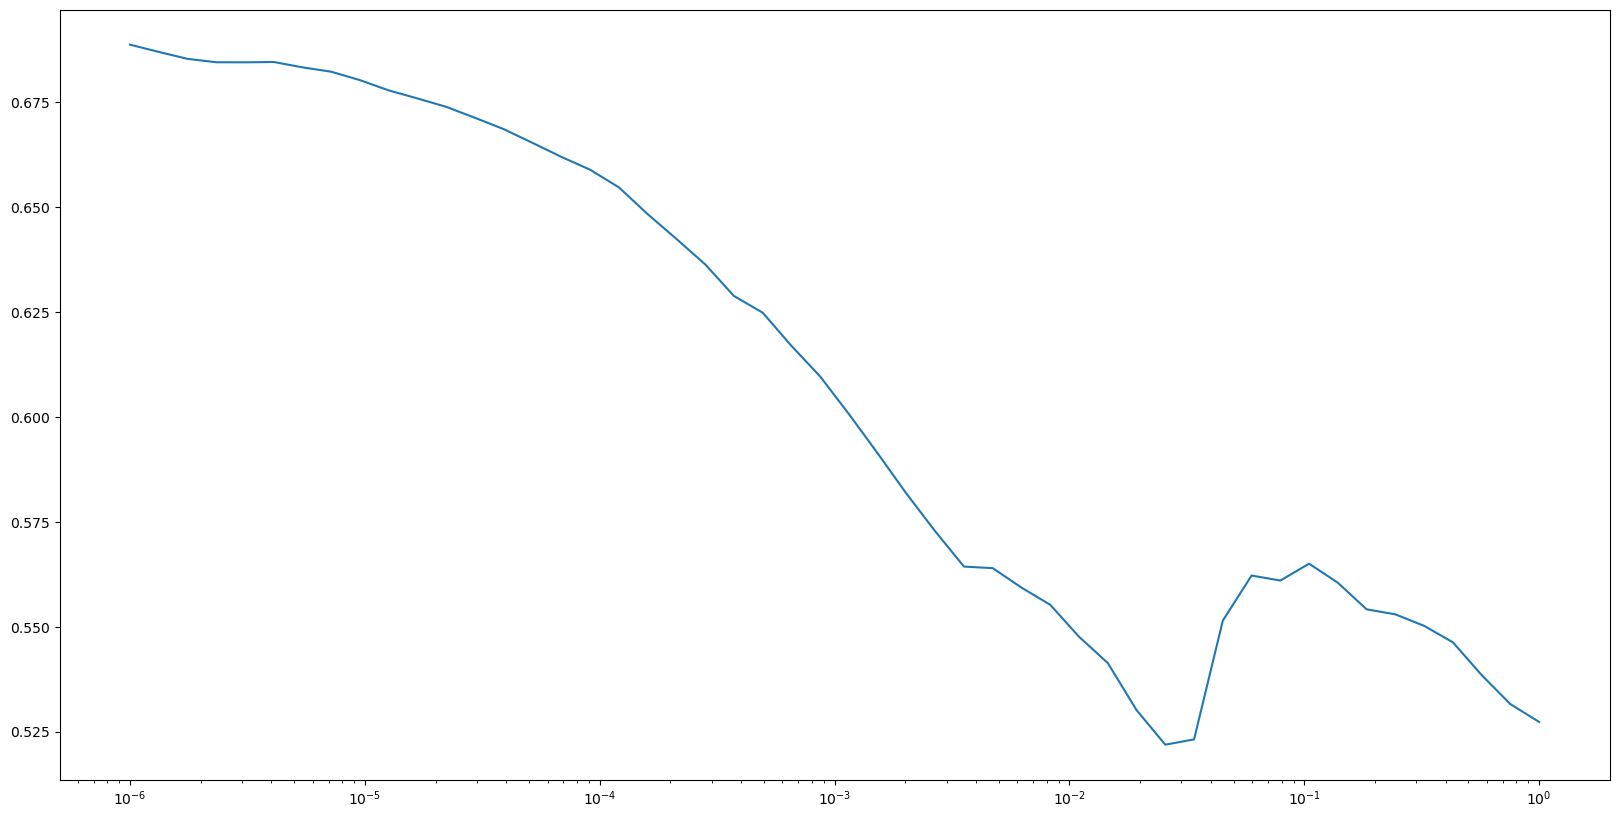

In [33]:
# plot loss vs lr
f1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(lg_lrs, losses)
ax1.set_xscale('log')
plt.show()

In [34]:
# define the model and train with scheduler
torch.manual_seed(42)
model = VisionTransformer(config_vit, img_size=img_size, num_classes=config_vit.n_classes).to(device)
model.load_from(weights=np.load(config_vit.pretrained_path))
#model = nn.DataParallel(model,device_ids = [1]) #[0,1,2,3])  # Para entrenar en varias tarjetas GPU
epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs,
                                                pct_start=0.43, div_factor=10, final_div_factor=1000, three_phase=True)

In [35]:
train(model, optimizer, scheduler, epochs=epochs)

Epoch 0, minibatch 25, train cost 0.339, train acc 0.873, val cost 0.202, val acc 0.922, dice 0.721, iou 0.564
Epoch 0, minibatch 50, train cost 0.269, train acc 0.894, val cost 0.168, val acc 0.927, dice 0.723, iou 0.567
Epoch 1, minibatch 25, train cost 0.194, train acc 0.922, val cost 0.172, val acc 0.923, dice 0.751, iou 0.601
Epoch 1, minibatch 50, train cost 0.174, train acc 0.929, val cost 0.133, val acc 0.944, dice 0.799, iou 0.665
Epoch 2, minibatch 25, train cost 0.147, train acc 0.938, val cost 0.130, val acc 0.943, dice 0.790, iou 0.654
Epoch 2, minibatch 50, train cost 0.145, train acc 0.939, val cost 0.124, val acc 0.950, dice 0.844, iou 0.730
Epoch 3, minibatch 25, train cost 0.136, train acc 0.946, val cost 0.153, val acc 0.938, dice 0.764, iou 0.619
Epoch 3, minibatch 50, train cost 0.135, train acc 0.945, val cost 0.116, val acc 0.953, dice 0.847, iou 0.734
Epoch 4, minibatch 25, train cost 0.114, train acc 0.952, val cost 0.118, val acc 0.950, dice 0.830, iou 0.710
E

torch.Size([16, 224, 224])


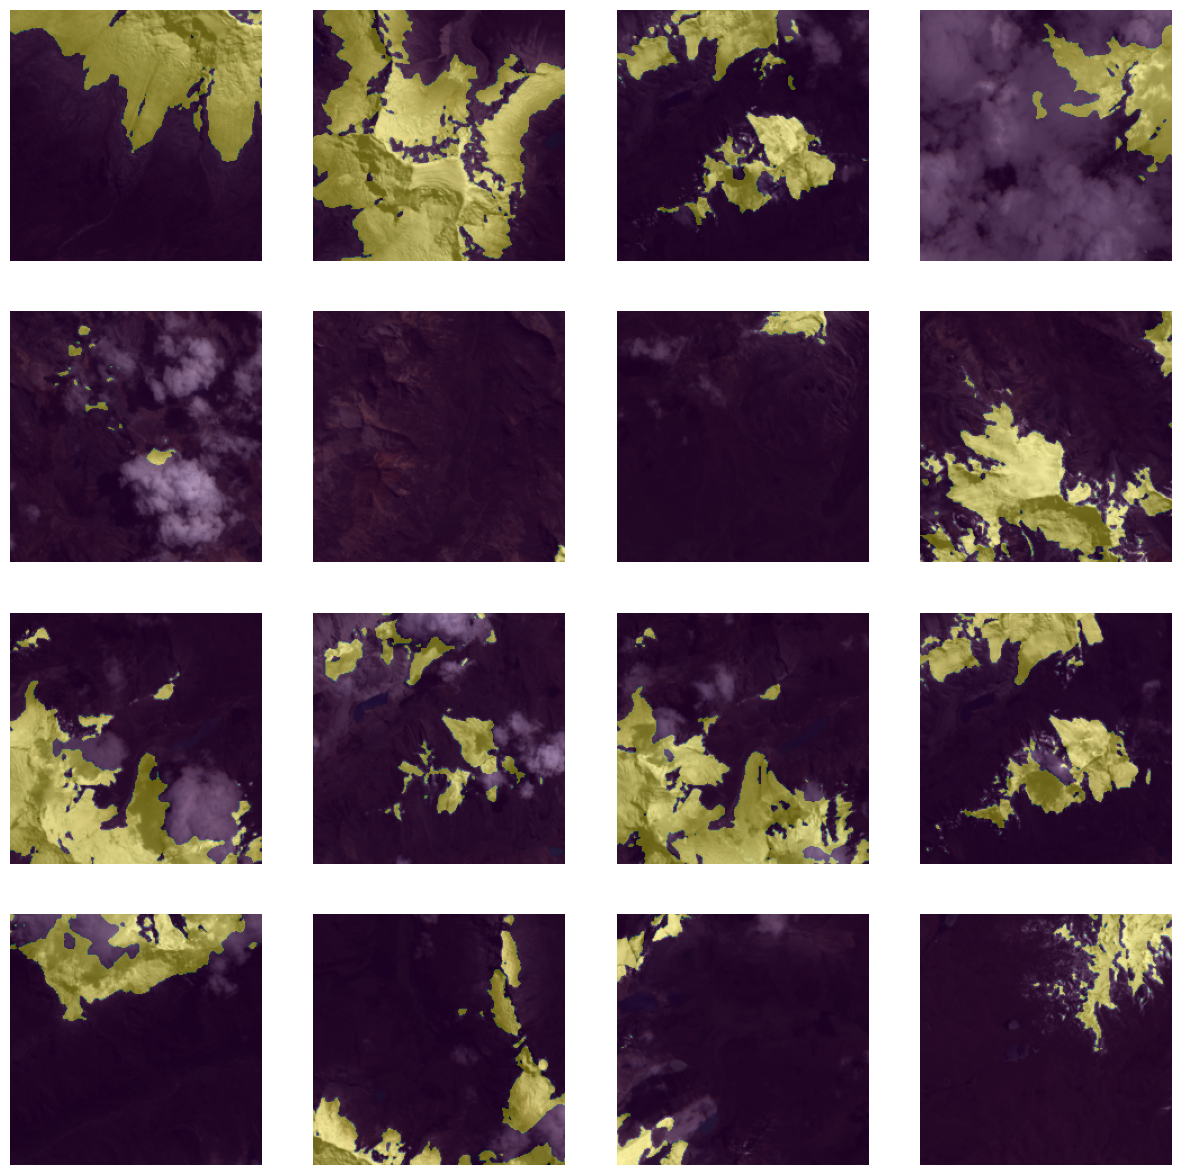

In [36]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

### Métricas

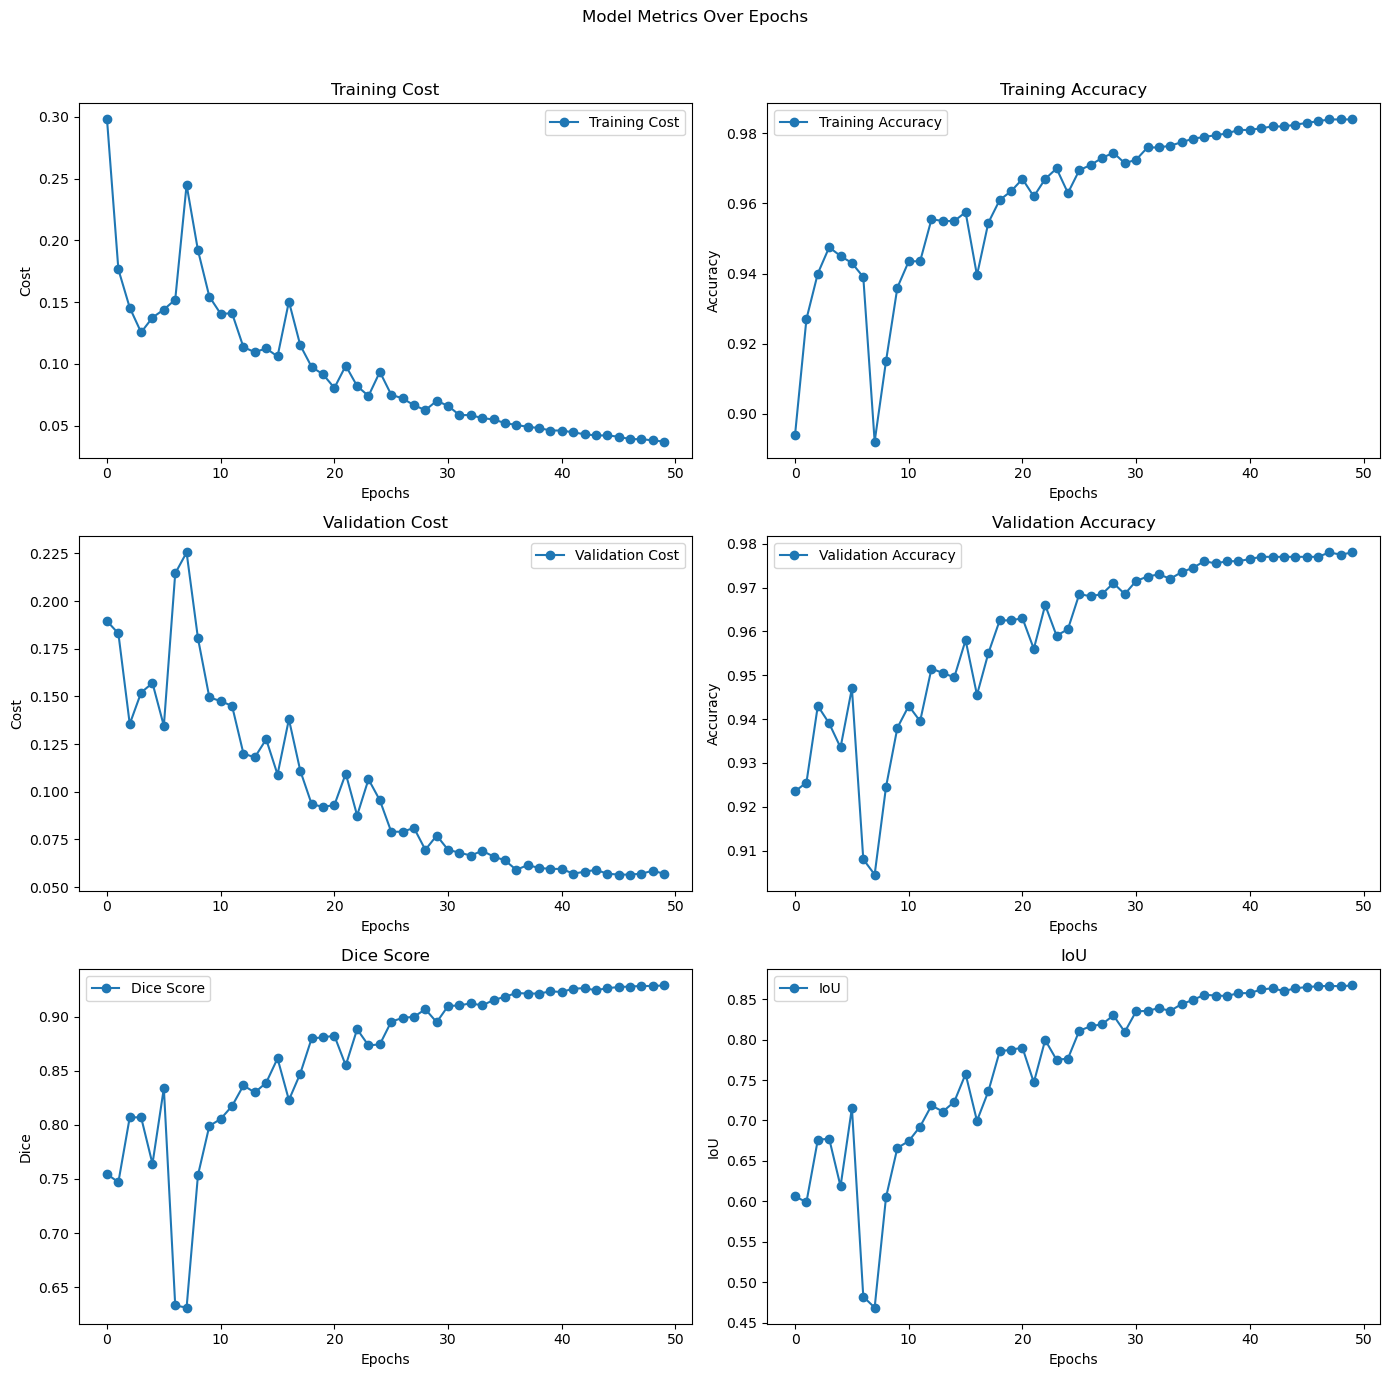

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Data for metrics over epochs and minibatches
data = [
    [0, 25, 0.333, 0.884, 0.189, 0.923, 0.766, 0.621],
    [0, 50, 0.263, 0.904, 0.190, 0.924, 0.743, 0.591],
    [1, 25, 0.180, 0.926, 0.215, 0.915, 0.701, 0.540],
    [1, 50, 0.173, 0.928, 0.151, 0.936, 0.793, 0.658],
    [2, 25, 0.153, 0.937, 0.138, 0.942, 0.811, 0.682],
    [2, 50, 0.138, 0.943, 0.133, 0.944, 0.803, 0.670],
    [3, 25, 0.122, 0.949, 0.135, 0.942, 0.825, 0.703],
    [3, 50, 0.129, 0.946, 0.169, 0.936, 0.789, 0.652],
    [4, 25, 0.137, 0.945, 0.161, 0.931, 0.752, 0.603],
    [4, 50, 0.138, 0.945, 0.153, 0.936, 0.776, 0.634],
    [5, 25, 0.150, 0.940, 0.139, 0.948, 0.832, 0.713],
    [5, 50, 0.138, 0.946, 0.130, 0.946, 0.836, 0.718],
    [6, 25, 0.143, 0.944, 0.162, 0.939, 0.789, 0.651],
    [6, 50, 0.161, 0.934, 0.267, 0.877, 0.477, 0.313],
    [7, 25, 0.255, 0.887, 0.265, 0.888, 0.533, 0.363],
    [7, 50, 0.235, 0.897, 0.186, 0.921, 0.729, 0.574],
    [8, 25, 0.198, 0.912, 0.198, 0.917, 0.733, 0.578],
    [8, 50, 0.186, 0.918, 0.163, 0.932, 0.774, 0.632],
    [9, 25, 0.148, 0.938, 0.147, 0.938, 0.812, 0.684],
    [9, 50, 0.161, 0.934, 0.152, 0.938, 0.786, 0.648],
    [10, 25, 0.135, 0.945, 0.136, 0.944, 0.817, 0.691],
    [10, 50, 0.146, 0.942, 0.159, 0.942, 0.794, 0.658],
    [11, 25, 0.143, 0.942, 0.157, 0.934, 0.804, 0.673],
    [11, 50, 0.139, 0.945, 0.133, 0.945, 0.831, 0.712],
    [12, 25, 0.112, 0.957, 0.118, 0.953, 0.843, 0.728],
    [12, 50, 0.115, 0.954, 0.122, 0.950, 0.830, 0.709],
    [13, 25, 0.105, 0.957, 0.124, 0.946, 0.801, 0.669],
    [13, 50, 0.114, 0.953, 0.112, 0.955, 0.859, 0.753],
    [14, 25, 0.112, 0.955, 0.143, 0.945, 0.823, 0.699],
    [14, 50, 0.113, 0.955, 0.112, 0.954, 0.855, 0.747],
    [15, 25, 0.106, 0.957, 0.095, 0.961, 0.875, 0.779],
    [15, 50, 0.106, 0.958, 0.123, 0.955, 0.848, 0.736],
    [16, 25, 0.159, 0.936, 0.155, 0.939, 0.816, 0.690],
    [16, 50, 0.142, 0.943, 0.121, 0.952, 0.830, 0.709],
    [17, 25, 0.117, 0.954, 0.121, 0.950, 0.824, 0.701],
    [17, 50, 0.113, 0.955, 0.101, 0.960, 0.871, 0.771],
    [18, 25, 0.095, 0.962, 0.090, 0.964, 0.887, 0.797],
    [18, 50, 0.100, 0.960, 0.097, 0.961, 0.873, 0.774],
    [19, 25, 0.091, 0.964, 0.097, 0.960, 0.875, 0.778],
    [19, 50, 0.092, 0.963, 0.087, 0.965, 0.887, 0.797],
    [20, 25, 0.079, 0.968, 0.097, 0.962, 0.878, 0.782],
    [20, 50, 0.082, 0.966, 0.089, 0.964, 0.887, 0.798],
    [21, 25, 0.099, 0.962, 0.118, 0.954, 0.838, 0.721],
    [21, 50, 0.098, 0.962, 0.101, 0.958, 0.872, 0.773],
    [22, 25, 0.082, 0.967, 0.082, 0.967, 0.894, 0.809],
    [22, 50, 0.082, 0.967, 0.093, 0.965, 0.883, 0.790],
    [23, 25, 0.067, 0.973, 0.092, 0.962, 0.887, 0.796],
    [23, 50, 0.081, 0.967, 0.121, 0.956, 0.860, 0.754],
    [24, 25, 0.095, 0.963, 0.096, 0.960, 0.877, 0.780],
    [24, 50, 0.092, 0.963, 0.095, 0.961, 0.872, 0.773],
    [25, 25, 0.077, 0.969, 0.077, 0.969, 0.897, 0.814],
    [25, 50, 0.073, 0.970, 0.081, 0.968, 0.894, 0.808],
    [26, 25, 0.069, 0.972, 0.080, 0.968, 0.899, 0.817],
    [26, 50, 0.075, 0.970, 0.078, 0.968, 0.899, 0.816],
    [27, 25, 0.066, 0.973, 0.082, 0.969, 0.897, 0.814],
    [27, 50, 0.067, 0.973, 0.080, 0.968, 0.903, 0.824],
    [28, 25, 0.063, 0.974, 0.069, 0.972, 0.910, 0.835],
    [28, 50, 0.062, 0.975, 0.070, 0.970, 0.904, 0.825],
    [29, 25, 0.071, 0.971, 0.077, 0.968, 0.892, 0.804],
    [29, 50, 0.069, 0.972, 0.077, 0.969, 0.898, 0.815],
    [30, 25, 0.069, 0.971, 0.070, 0.972, 0.909, 0.834],
    [30, 50, 0.063, 0.974, 0.069, 0.971, 0.911, 0.836],
    [31, 25, 0.058, 0.976, 0.068, 0.972, 0.909, 0.832],
    [31, 50, 0.059, 0.976, 0.068, 0.973, 0.912, 0.839],
    [32, 25, 0.059, 0.976, 0.067, 0.973, 0.911, 0.836],
    [32, 50, 0.058, 0.976, 0.066, 0.973, 0.914, 0.842],
    [33, 25, 0.055, 0.977, 0.071, 0.972, 0.907, 0.829],
    [33, 50, 0.057, 0.976, 0.067, 0.972, 0.914, 0.842],
    [34, 25, 0.056, 0.977, 0.066, 0.973, 0.914, 0.842],
    [34, 50, 0.054, 0.978, 0.066, 0.974, 0.917, 0.846],
    [35, 25, 0.051, 0.979, 0.065, 0.974, 0.917, 0.846],
    [35, 50, 0.053, 0.978, 0.063, 0.975, 0.920, 0.852],
    [36, 25, 0.051, 0.979, 0.060, 0.976, 0.921, 0.854],
    [36, 50, 0.050, 0.979, 0.058, 0.976, 0.923, 0.857],
    [37, 25, 0.049, 0.980, 0.061, 0.976, 0.921, 0.854],
    [37, 50, 0.049, 0.979, 0.062, 0.975, 0.922, 0.855],
    [38, 25, 0.048, 0.980, 0.060, 0.976, 0.921, 0.853],
    [38, 50, 0.048, 0.980, 0.060, 0.976, 0.922, 0.855],
    [39, 25, 0.046, 0.981, 0.061, 0.976, 0.923, 0.857],
    [39, 50, 0.046, 0.981, 0.058, 0.976, 0.924, 0.858],
    [40, 25, 0.046, 0.981, 0.062, 0.976, 0.921, 0.854],
    [40, 50, 0.046, 0.981, 0.057, 0.977, 0.925, 0.861],
    [41, 25, 0.045, 0.981, 0.057, 0.977, 0.926, 0.862],
    [41, 50, 0.044, 0.982, 0.057, 0.977, 0.926, 0.862],
    [42, 25, 0.043, 0.982, 0.059, 0.977, 0.926, 0.862],
    [42, 50, 0.043, 0.982, 0.057, 0.977, 0.927, 0.865],
    [43, 25, 0.042, 0.982, 0.058, 0.977, 0.925, 0.861],
    [43, 50, 0.042, 0.982, 0.060, 0.977, 0.924, 0.859],
    [44, 25, 0.042, 0.982, 0.057, 0.977, 0.927, 0.864],
    [44, 50, 0.042, 0.983, 0.057, 0.977, 0.926, 0.863],
    [45, 25, 0.041, 0.983, 0.056, 0.977, 0.927, 0.865],
    [45, 50, 0.041, 0.983, 0.057, 0.977, 0.928, 0.865],
    [46, 25, 0.038, 0.984, 0.056, 0.977, 0.928, 0.866],
    [46, 50, 0.040, 0.983, 0.057, 0.977, 0.928, 0.866],
    [47, 25, 0.039, 0.984, 0.057, 0.978, 0.929, 0.867],
    [47, 50, 0.039, 0.984, 0.057, 0.978, 0.928, 0.866],
    [48, 25, 0.038, 0.984, 0.061, 0.977, 0.928, 0.865],
    [48, 50, 0.038, 0.984, 0.056, 0.978, 0.929, 0.867],
    [49, 25, 0.037, 0.984, 0.058, 0.978, 0.929, 0.867],
    [49, 50, 0.037, 0.984, 0.056, 0.978, 0.929, 0.867],
]

# Aggregating the metrics by epoch
epochs = sorted(set(row[0] for row in data))
epoch_metrics = {epoch: [] for epoch in epochs}

for row in data:
    epoch_metrics[row[0]].append(row[2:])

# Averaging the metrics within each epoch
avg_train_costs = []
avg_train_accuracies = []
avg_val_costs = []
avg_val_accuracies = []
avg_dice_scores = []
avg_ious = []

for epoch in epochs:
    metrics = np.mean(epoch_metrics[epoch], axis=0)
    avg_train_costs.append(metrics[0])
    avg_train_accuracies.append(metrics[1])
    avg_val_costs.append(metrics[2])
    avg_val_accuracies.append(metrics[3])
    avg_dice_scores.append(metrics[4])
    avg_ious.append(metrics[5])

# Plotting the metrics
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
fig.suptitle('Model Metrics Over Epochs')

# Training Cost
axes[0, 0].plot(epochs, avg_train_costs, label='Training Cost', marker='o')
axes[0, 0].set_title('Training Cost')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Cost')
axes[0, 0].legend()

# Training Accuracy
axes[0, 1].plot(epochs, avg_train_accuracies, label='Training Accuracy', marker='o')
axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Validation Cost
axes[1, 0].plot(epochs, avg_val_costs, label='Validation Cost', marker='o')
axes[1, 0].set_title('Validation Cost')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Cost')
axes[1, 0].legend()

# Validation Accuracy
axes[1, 1].plot(epochs, avg_val_accuracies, label='Validation Accuracy', marker='o')
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Dice Score
axes[2, 0].plot(epochs, avg_dice_scores, label='Dice Score', marker='o')
axes[2, 0].set_title('Dice Score')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].set_ylabel('Dice')
axes[2, 0].legend()

# IoU
axes[2, 1].plot(epochs, avg_ious, label='IoU', marker='o')
axes[2, 1].set_title('IoU')
axes[2, 1].set_xlabel('Epochs')
axes[2, 1].set_ylabel('IoU')
axes[2, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [40]:
# Extract the last row of data for the final epoch and minibatch 50
final_data = [row for row in data if row[0] == 49 and row[1] == 50][0]

# Final values of the metrics
final_epoch = final_data[0]
final_minibatch = final_data[1]
final_train_cost = final_data[2]
final_train_acc = final_data[3]
final_val_cost = final_data[4]
final_val_acc = final_data[5]
final_dice = final_data[6]
final_iou = final_data[7]

print(f"Final metrics at Epoch {final_epoch}, Minibatch {final_minibatch}:")
print(f"Train Cost: {final_train_cost:.3f}")
print(f"Train Accuracy: {final_train_acc:.3f}")
print(f"Validation Cost: {final_val_cost:.3f}")
print(f"Validation Accuracy: {final_val_acc:.3f}")
print(f"Dice Score: {final_dice:.3f}")
print(f"IoU: {final_iou:.3f}")

Final metrics at Epoch 49, Minibatch 50:
Train Cost: 0.037
Train Accuracy: 0.984
Validation Cost: 0.056
Validation Accuracy: 0.978
Dice Score: 0.929
IoU: 0.867


### Test

In [45]:
base_path = '/home/eoyarce/segmentacion-tesis-2/model/new_datatest'
TRAIN_PATH = os.path.join(base_path, 'ImagesPNG')
TRAIN_MASKS_PATH = os.path.join(base_path, 'Mask_0.4')

In [46]:
test_dataset = CustomDataset(TRAIN_PATH, TRAIN_MASKS_PATH, img_transforms=transform_data, mask_transforms=transform_data)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
BATCH_SIZE = 16
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Define the accuracy function
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost += F.cross_entropy(scores, y).item()
            # Standard accuracy calculation
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            # Dice coefficient calculation
            intersection += (preds * y).sum()
            denom += (preds + y).sum()
            dice = 2 * intersection / (denom + 1e-8)
            # IoU calculation
            union += (preds | y).sum()
            iou = intersection / (union + 1e-8)
    return cost / len(loader), float(correct) / total, dice.item(), iou.item()

# Load the trained TransUNet model from file
TransUNet = VisionTransformer(config_vit, img_size=img_size, num_classes=config_vit.n_classes)
model = TransUNet  # Assuming TransUNet has similar input/output channels as UNet_simple
#state_dict = load_model_with_parallel('/path/to/your/TransUNetModel.pth')
#state_dict = remove_module_from_state_dict(state_dict)
model.load_state_dict(torch.load('/home/eoyarce/segmentacion-tesis-2/model/TransUNetModel.pth', map_location=device))
model.eval()

# Initialize metrics
test_loss = 0.0
test_iou = 0.0
test_dice = 0.0

# Evaluate the model on the test dataset
test_loss, _, test_dice, test_iou = accuracy(model, test_loader)

# Print the results
print(f"*** Test Loss: {test_loss:.4f}, Test Dice: {test_dice:.4f}, Test IoU: {test_iou:.4f}")


*** Test Loss: 0.1555, Test Dice: 0.8589, Test IoU: 0.7527
